In [149]:
import matplotlib.pyplot as plt, torch

In [150]:
torch.manual_seed(42)
torch.set_printoptions(precision=3, linewidth=140, sci_mode=False)

In [151]:
from torch import tensor
from torch.distributions.multivariate_normal import MultivariateNormal


In [152]:
n_samples = 250
n_clusters = 6

In [153]:
centroids = torch.rand(n_clusters,2)*70-35
centroids

tensor([[ 26.759,  29.050],
        [ -8.200,  32.151],
        [ -7.669,   7.063],
        [-17.040,  20.555],
        [ 30.854, -25.677],
        [ 30.422,   6.551]])

In [154]:
def sample(m):
    return MultivariateNormal(m, torch.diag(tensor([5.,5]))).sample((n_samples,))

In [155]:
s = [sample(c) for c in centroids]
data = torch.cat(s)
data.shape

torch.Size([1500, 2])

In [156]:
def plot_data(data):
    _,ax = plt.subplots()
    ax.scatter(data[:,0], data[:,1], s=2)

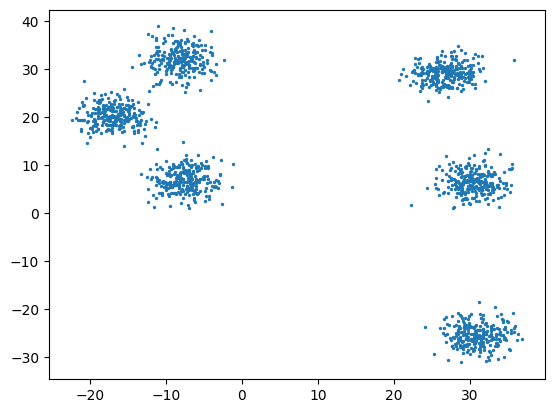

In [157]:
plot_data(data)

In [159]:
def dist(a,b):
    return ((a-b)**2).sum(1).sqrt()

In [212]:
def get_neighbours(data, dist_func, point, eps):
    dist = dist_func(data, point)
    return torch.nonzero(dist <= eps).flatten()

In [213]:
dists = dist(data[0], data)
dists[:10]

tensor([0.000, 3.899, 4.834, 3.726, 6.273, 4.122, 6.560, 6.002, 3.488, 5.129])

In [214]:
n = get_neighbours(data, dist, data[0], 10)
n[:10]

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [238]:
def expand(data, dist_func, i, c, eps, min_pts, labels, neighbours):
    labels[i] = c

    k = 0

    while k < len(neighbours):
        if labels[neighbours[k]] != -1:
            k += 1
            continue
        labels[neighbours[k]] = c
        n_k = get_neighbours(data, dist_func, data[neighbours[k]], eps)
        if len(n_k) >= min_pts:
            neighbours = torch.unique(torch.cat((neighbours, n_k)))

        k += 1 

    

In [241]:
def dbscan(data, dist_func, eps, min_pts):
    c = 0
    labels = torch.full((data.shape[0],), -1)
    for i in range(data.shape[0]):
        if labels[i] != -1:
            continue # already visited
        neighbours = get_neighbours(data, dist_func, data[i], eps)
        if len(neighbours) < min_pts:
            labels[i] = -2 # label the point as noise
            continue
        
        c += 1
        expand(data, dist_func, i, c, eps, min_pts, labels, neighbours)
    return labels   
                

In [359]:
X = data.clone()
labels = dbscan(X, dist, 5, 200)

In [360]:
labels[:10]

tensor([-2,  1,  1,  1, -2, -2,  1,  1,  1,  1])

In [361]:
len(torch.unique(labels))

7

In [362]:
torch.unique(labels)

tensor([-2,  1,  2,  3,  4,  5,  6])

In [363]:
label_colors = {-2:'brown', 1:'blue', 2:'green', 3:'yellow', 4:'orange', 5:'black', 6:'magenta', 7:'cyan'}

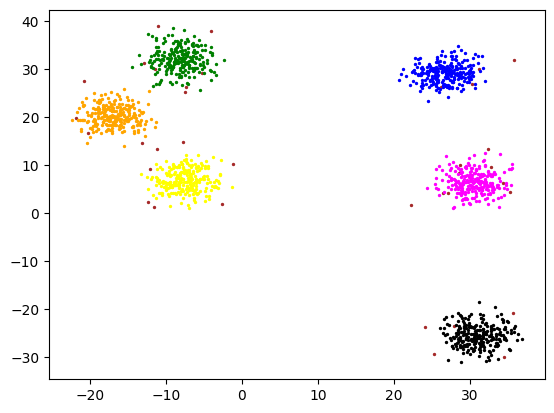

In [364]:
for i, x in enumerate(data):
    cluster = labels[i]
    plt.scatter(x[0], x[1], s=2, c=label_colors[cluster.item()])